In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import copy
import ipdb


# Parameters:
ANCHORS = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # Anchors as tensor: (height, width, height, z_center, orientation)
                       [1.6, 3.9, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.6, 0.8, 1.73, -0.6, 1.5708]]
                       )

# Map anchors to image:
def map_to_img(value: float, pillar_size: tuple, min_value: float):
    mapped_value = (value - min_value) // pillar_size[0] # Floored division
    assert mapped_value >= 0.0
    return mapped_value

# Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)
RADIUS_MARGIN = 20.0 # In feature map


mapped_anchors = ANCHORS.detach().clone()

for anchor in mapped_anchors: # Overrides anchors height, width with mapped length and width
  anchor[0] = map_to_img(value=anchor[0], pillar_size=PILLAR_SIZE, min_value=0.0) # 0.0 as min_value since length is already a delta
  anchor[1] = map_to_img(value=anchor[1], pillar_size=PILLAR_SIZE, min_value=0.0) # 0.0 as min_value since width is already a delta



Create the random image for the test of the algorithm:

In [2]:
# Define the dimensions of the image
H = 500  # Height
W = 440  # Width

# Generate a random tensor of shape (H*W, 3) for a color image (3 channels)
random_tensor = torch.randn(H * W, 3)

# Reshape the tensor to match the image dimensions (H, W, C)
random_image = random_tensor.reshape(H, W, 3)

# Ensure the values are in the [0, 1] range (assuming you want a [0, 1] normalized image)
random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())
random_image = random_image.permute(2, 0, 1)
batched_random_image = random_image.unsqueeze(0) # Add batch size dim

In [3]:
# Create 2D bounding box Class:
class Box2D():
    def __init__(self, x_lims: tuple, y_lims: tuple, x_anchor: float, y_anchor: float, height: float, width: float):
        super().__init__()    
        self.x_anchor = x_anchor
        self.y_anchor = y_anchor
        self.height = height
        self.width = width
        self.x_max = self.x_anchor + self.width
        self.y_max = self.y_anchor + self.height
        self.x_lims = x_lims
        self.y_lims = y_lims



    def create_marker(self, color='r'):
        return(patches.Rectangle((self.x_anchor, self.y_anchor), width=self.width, 
                height=self.height, linewidth=2, edgecolor=color, facecolor='none'))
    

    def create_ROI(self, margin: float): 
        '''Returns a Box2D type with ROI'''
        ROI_box = copy.copy(self)
        ROI_box.x_anchor = self.x_anchor - margin
        ROI_box.y_anchor = self.y_anchor - margin
        ROI_box.height = self.height + 2*margin
        ROI_box.width = self.width + 2*margin

        # Clamp if ROI is out of the feature_map before returning:
        if (ROI_box.x_anchor < self.x_lims[0]): 
        ROI_box.x_anchor = self.x_lims[0]
        elif (ROI_box.x_anchor + ROI_box.width > self.x_lims[1]):
        ROI_box.x_anchor = self.x_lims[1]
        
        if (ROI_box.y_anchor < self.y_lims[0]):
        ROI_box.y_anchor = self.y_lims[0]
        elif (ROI_box.y_anchor + ROI_box.height > self.y_lims[1]):
        ROI_box.y_anchor = self.y_lims[1]

        return ROI_box
    

# Create anchors class:
class Anchor():
    def __init__(self, width, height, rotations=0.0):
        super().__init__()  
          
        self.width = width
        self.height = height

    def create_anchor_grid(self, feature_map): 

        '''In: feature map (bs, C, H, W)
            Returns: (grid_x, grid_y): ()
        '''
        
        self.num_anchors_x = int(torch.round(batched_random_image.size()[-1] / anchor.width)) 
        self.num_anchors_y = int(torch.round(batched_random_image.size()[-2] / anchor.height))
        self.grid_x = torch.linspace(0, feature_map.size()[-1], self.num_anchors_x) 
        self.grid_y = torch.linspace(0, feature_map.size()[-2], self.num_anchors_y) 
    
    def get_ROI_indices(self, feature_map, ROIs_list):

        '''In: feature_map, (bs, C, H, W),
            ROIs_list: list(Box2D)
            Out: {ROI #, list((idx_x_min, idx_y_min), (idx_x_max, idx_y_max))}
        '''

        ROIs_indices = {}
        for ROI in ROIs_list:
            # Find the indices in grid_x and grid_y for the given (x_min, y_min) point of anchor:
            idx_x_min = int(torch.searchsorted(self.grid_x, ROI.x_anchor, right=True))
            idx_y_min = int(torch.searchsorted(self.grid_y, ROI.y_anchor, right=True))

            idx_x_max = int(torch.searchsorted(self.grid_x, ROI.x_max, right=True))
            idx_y_max = int(torch.searchsorted(self.grid_y, ROI.y_max, right=True))
            ROIs_indices[ROI] = [(idx_x_min, idx_y_min), (idx_x_max, idx_y_max)] 
        
        return ROIs_indices 


        
# Define the IoU function
def calculate_iou(box1, box2):
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1.x_anchor, box2.x_anchor)
    y_top = max(box1.y_anchor, box2.y_anchor)
    x_right = min(box1.x_anchor + box1.width, box2.x_anchor + box2.width)
    y_bottom = min(box1.y_anchor + box1.height, box2.y_anchor + box2.height)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area of intersection rectangle
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    box1_area = box1.width * box1.height
    box2_area = box2.width * box2.height

    # Calculate union area
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area

    return iou

            



4
5
6
4
tensor(0.0422)
5
6
4
tensor(0.2400)
5
6
4
5
6
8
9
8
tensor(0.1026)
9
8
tensor(0.2667)
9
8
9
8
9
8
9
10
11
12
13
14
18
19
20
21
22
18
19
20
21
22
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
16
17
18
19
20
21
22
23
24
25
26
27
28
29
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
36
37
38
39
40
41
42
43
44
45
3

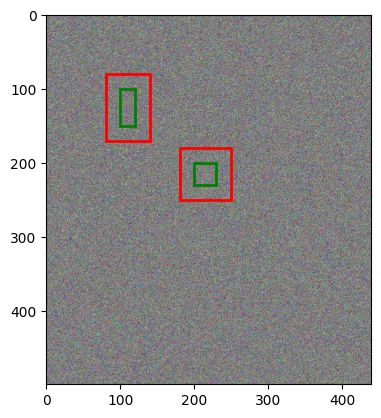

In [7]:

# Create a figure and axis for displaying the image
fig, ax = plt.subplots() # TODO: Move to the bottom


# Create ground truth bounding box coordinates and add rectangles to the image
gt_boxes = [Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=100, y_anchor=100, height=50, width=20), 
  Box2D(x_lims=(0, W), y_lims=(0, H), x_anchor=200, y_anchor=200, height=30, width=30)]
markers = []

roi_boxes = []

# Define ROIs and add marker for visualization:
for box in gt_boxes:
  roi_box = box.create_ROI(margin=RADIUS_MARGIN)
  roi_boxes.append(roi_box)
  ax.add_patch(roi_box.create_marker())
  ax.add_patch(box.create_marker(color='g'))

 
# Generate anchors with Anchor class:
anchors_list = []

for i in range(len(mapped_anchors)):
  anchor = Anchor(width=mapped_anchors[i][1], height=mapped_anchors[i][0])
  num_anchors_x = int(torch.round(batched_random_image.size()[-1] / anchor.width))  # TODO: Add num_anchors_x and y as class attributes
  num_anchors_y = int(torch.round(batched_random_image.size()[-2] / anchor.height)) # TODO: Change to real batch of pseudo-images
  anchor.create_anchor_grid(batched_random_image)
  anchors_list.append(anchor)
  


# TODO: Create a list of ROI_dicts (Is this still needed?)

''' Gets best detection fit per anchor per target
    Desired output: {target: best_anchor}, a dictionary of size n_targets
'''
current_iou = 0.0 # Intersection over union as a metric to determine which anchor best fits the regression target
gt_with_target_anchor_dict = {key: (None, (None, None), current_iou) for key in gt_boxes} # Initialize dictionary with IoU = 0.0

for anchor in anchors_list:  # Next anchor
  # Create grid on feature map with the current anchor
  # anchor.create_anchor_grid(batched_random_image) FIXME: DEPRECATE?
  ROI_dict = anchor.get_ROI_indices(batched_random_image, roi_boxes) # 

  for n_target, ROI in enumerate(ROI_dict): # Next label
    gt_target = gt_boxes[n_target]
    lower_x_idx, lower_y_idx = ROI_dict[ROI][0][0], ROI_dict[ROI][0][1]
    upper_x_idx, upper_y_idx = ROI_dict[ROI][1][0], ROI_dict[ROI][1][1]


    if (gt_with_target_anchor_dict[gt_target][-1] >= 0.5): # Already matched
      continue

    found_target = False # breaker of feature_map scan iterator
    current_iou = 0.0 # Refresh iou before searching again
    for i in range(lower_x_idx, upper_x_idx):
      if found_target: 
        break

      for j in range(lower_y_idx, upper_y_idx):
        anchor_box = Box2D( # Class should be declared before calling this ibject
          x_lims=(0.0, batched_random_image.size()[-1]), y_lims=(0.0, batched_random_image.size()[-2]),
          x_anchor=anchor.grid_x[i], y_anchor=anchor.grid_y[j], height=anchor.height, width=anchor.width)
        
        current_iou = calculate_iou(anchor_box, gt_target)
        if current_iou > gt_with_target_anchor_dict[gt_target][-1]:
          print(current_iou)
          gt_with_target_anchor_dict[gt_target] = (anchor, (i,j), current_iou)

          if current_iou >= 0.5:
            found_target = True # Target for the anchor found (ignore rest even if higher IoU)
            break # Break 2 for loops
            

#for x in anchor1.grid_x: #FIXME: Hardcoded anchor and uncomment to visualize anchor grids
#    ax.axvline(x=x, color='b', alpha=0.5)

#for y in anchor1.grid_y: # FIXME: Hardcoded anchor
#    ax.axhline(y=y, color='b', alpha=0.5)


# Display the image using imshow
ax.imshow(batched_random_image[0].permute(1, 2, 0)) # Plot batched_image here





In [5]:
gt_with_target_anchor_dict

{<__main__.Box2D at 0x7f11714e2580>: (<__main__.Anchor at 0x7f11714e0550>,
  (10, 4),
  tensor(0.2400)),
 <__main__.Box2D at 0x7f11714e2280>: (<__main__.Anchor at 0x7f11714e0550>,
  (20, 8),
  tensor(0.2667))}